In [18]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import mediapipe as mp

mp_facemesh = mp.solutions.face_mesh
mp_drawing = mp.solutions.drawing_utils
denormalize_coordinates = mp_drawing._normalized_to_pixel_coordinates

In [19]:
# Landmark points corresponding to left eye
all_left_eye_idxs = list(mp_facemesh.FACEMESH_LEFT_EYE)
# flatten and remove duplicates
all_left_eye_idxs = set(np.ravel(all_left_eye_idxs))

# Landmark points corresponding to right eye
all_right_eye_idxs = list(mp_facemesh.FACEMESH_RIGHT_EYE)
all_right_eye_idxs = set(np.ravel(all_right_eye_idxs))

# Combined for plotting - Landmark points for both eye
all_idxs = all_left_eye_idxs.union(all_right_eye_idxs)

# The chosen 12 points:   P1,  P2,  P3,  P4,  P5,  P6
chosen_left_eye_idxs = [362, 385, 387, 263, 373, 380]
chosen_right_eye_idxs = [33, 160, 158, 133, 153, 144]
all_chosen_idxs = chosen_left_eye_idxs + chosen_right_eye_idxs

In [20]:
def distance(point_1, point_2):
    """Calculate l2-norm between two points"""
    dist = sum([(i - j) ** 2 for i, j in zip(point_1, point_2)]) ** 0.5
    return dist

def get_ear(landmarks, refer_idxs, frame_width, frame_height):
    """
    Calculate Eye Aspect Ratio for one eye.

    Args:
        landmarks: (list) Detected landmarks list
        refer_idxs: (list) Index positions of the chosen landmarks
                            in order P1, P2, P3, P4, P5, P6
        frame_width: (int) Width of captured frame
        frame_height: (int) Height of captured frame

    Returns:
        ear: (float) Eye aspect ratio
    """
    try:
        # Compute the euclidean distance between the horizontal
        coords_points = []
        for i in refer_idxs:
            lm = landmarks[i]
            coord = denormalize_coordinates(lm.x, lm.y, 
                                             frame_width, frame_height)
            coords_points.append(coord)

        # Eye landmark (x, y)-coordinates
        P2_P6 = distance(coords_points[1], coords_points[5])
        P3_P5 = distance(coords_points[2], coords_points[4])
        P1_P4 = distance(coords_points[0], coords_points[3])

        # Compute the eye aspect ratio
        ear = (P2_P6 + P3_P5) / (2.0 * P1_P4)

    except:
        ear = 0.0
        coords_points = None

    return ear, coords_points

In [21]:
def calculate_avg_ear(landmarks, left_eye_idxs, right_eye_idxs, image_w, image_h):
    """Calculate Eye aspect ratio"""

    left_ear, left_lm_coordinates = get_ear(landmarks, left_eye_idxs, image_w, image_h)
    right_ear, right_lm_coordinates = get_ear(
        landmarks, right_eye_idxs, image_w, image_h
    )
    Avg_EAR = (left_ear + right_ear) / 2.0

    return Avg_EAR, (left_lm_coordinates, right_lm_coordinates)

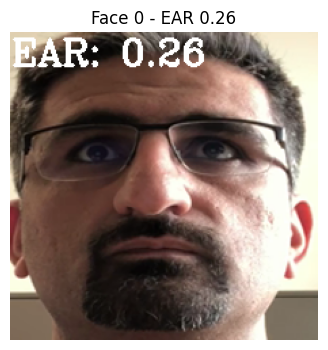

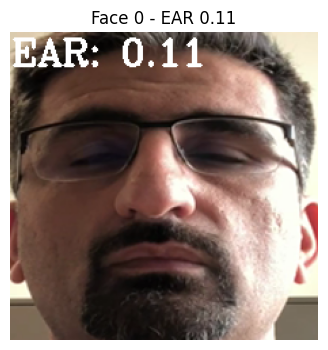

In [22]:
image_eyes_close = cv2.imread(r"archive\custom\drowsy\a0020.png")[:, :, ::-1]
image_eyes_open = cv2.imread(r"archive\custom\non_drowsy\a0019.png")[:, :, ::-1]

for idx, image in enumerate([image_eyes_open, image_eyes_close]):

    image = np.ascontiguousarray(image)
    imgH, imgW, _ = image.shape

    # Creating a copy of the original image for plotting the EAR value
    custom_chosen_lmk_image = image.copy()

    # Running inference using static_image_mode
    with mp_facemesh.FaceMesh(refine_landmarks=True) as face_mesh:
        results = face_mesh.process(image).multi_face_landmarks

        # If detections are available.
        if results:
            for face_id, face_landmarks in enumerate(results):
                landmarks = face_landmarks.landmark
                EAR, _ = calculate_avg_ear(
                    landmarks, chosen_left_eye_idxs, chosen_right_eye_idxs, imgW, imgH
                )

                # Print the EAR value on the custom_chosen_lmk_image.
                cv2.putText(
                    custom_chosen_lmk_image,
                    f"EAR: {round(EAR, 2)}",
                    (1, 24),
                    cv2.FONT_HERSHEY_COMPLEX,
                    0.9,
                    (255, 255, 255),
                    2,
                )

                # 显示叠加了关键点/文本的图像
                plt.figure(figsize=(6, 4))
                plt.imshow(custom_chosen_lmk_image)
                plt.axis("off")
                plt.title(f"Face {face_id} - EAR {round(EAR, 2)}")
                plt.show()